# Tutorial on visualization of Neural Networks

This exercise aims at exploring different ways of visualizing Neural Networks:
- t-SNE of representations (CIFAR10)
- grad-CAM (ImageNet)
- activation maximization (ImageNet)

First, some preliminaries that facilitate plotting and data access on Google drive ... just execute ! 

In [2]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
%load_ext autoreload
%autoreload 2

import importlib.util
import sys
from google.colab import drive
drive.mount('/content/gdrive')

#%cd /content/gdrive/My\ Drive/Colab\ Notebooks/dlia_course/practical_sessions/


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# basic imports
import os
import time

# import keras and tensorflow classes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# check the hardware settings
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# use GPU as hardware acceleration.
tf.device('/device:GPU:0')

# Visualization of the encodings by t-SNE

First, we will visualize encodings of a network trained on the CIFAR data set. Here, we import and preprocess the data. We keep the original labels in `y_data` (to be used for visualization later on). For training, we need to transform them to one-hot-vectors.

In [4]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_data, y_data), (x_test, y_test) = cifar10.load_data()

# preprocessing (normalization)
x_data = x_data.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# encodings in one-hot-vectors
y_train_cat = to_categorical(y_data)
y_test_cat = to_categorical(y_test)

# train/val separation
x_train = x_data[:40000]
x_val = x_data[40000:]
y_train = y_train_cat[:40000]
y_val = y_train_cat[40000:]


170498071/170498071 [==============================] - 6s 0us/step


We will first visualize the data. 

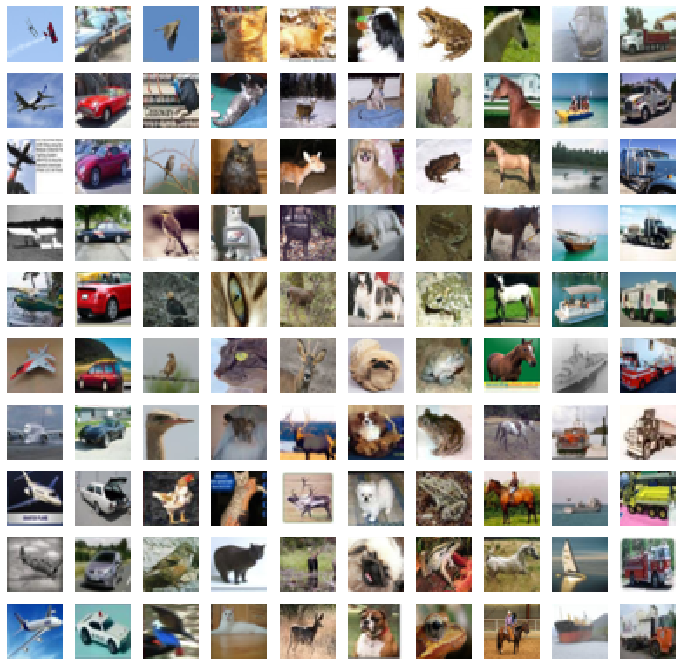

In [5]:
# helper function to plot a few images for each class
def plot_array(fig, X, Y, classes_to_plot=None, samples_per_class=7):
    if classes_to_plot is None:
        classes_to_plot = np.unique(Y)
    num_classes = len(classes_to_plot)

    for k, y in enumerate(classes_to_plot):
        idxs = np.flatnonzero(Y == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        #print(y, idxs)

        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + k + 1
            ax = fig.add_subplot(samples_per_class, num_classes, plt_idx)
            ax.imshow(X[idx].astype(np.uint8))
            ax.axis('off')
fig = plt.figure(figsize=(12, 12))
plot_array(fig, x_data*255, y_data, samples_per_class=10)

Next we define a neural network and train it on the data set. We output the model summary. The model summary gives you also the names of each of the layers. 

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# compile model
opt = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

Now, we train the neural network, we observe training and validation error, and we try to get a solution that roughly obtains 75\% or more on the test set. 

In [7]:
# model fit
history = model.fit(x_train, y_train, epochs=10, batch_size=64, 
                    validation_data=(x_val, y_val))

Epoch 1/10
625/625 [==============================] - 17s 11ms/step - loss: 1.6961 - accuracy: 0.3857 - val_loss: 1.2700 - val_accuracy: 0.5416
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 1.2116 - accuracy: 0.5716 - val_loss: 1.0243 - val_accuracy: 0.6404
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 1.0014 - accuracy: 0.6482 - val_loss: 0.8693 - val_accuracy: 0.6959
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.8865 - accuracy: 0.6922 - val_loss: 0.8300 - val_accuracy: 0.7125
Epoch 5/10
625/625 [==============================] - 7s 10ms/step - loss: 0.7988 - accuracy: 0.7229 - val_loss: 0.7626 - val_accuracy: 0.7395
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.7433 - accuracy: 0.7443 - val_loss: 0.6914 - val_accuracy: 0.7610
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6946 - accuracy: 0.7595 - val_loss: 0.6738 - val_accuracy: 0.7728


In [8]:
model.evaluate(x=x_test, y=y_test_cat)

313/313 [==============================] - 1s 4ms/step - loss: 0.7053 - accuracy: 0.7720


[0.7052979469299316, 0.7720000147819519]

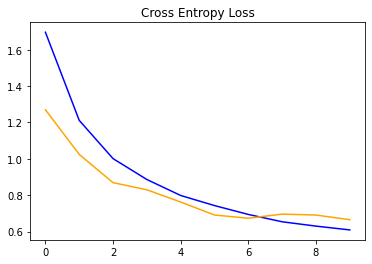

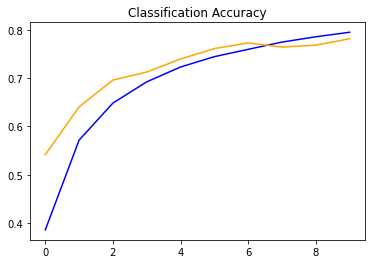

In [9]:
# We plot the learning curves (loss and accuracy)

# plot loss
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='training loss')
plt.plot(history.history['val_loss'], color='orange', label='validation loss')
plt.show()

# plot accuracy
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='training acc')
plt.plot(history.history['val_accuracy'], color='orange', label='validation acc')
plt.show()


Now, we need to define a few plots ... just execute !

In [10]:
class_definition = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 
                    4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 
                    9: 'truck'}

from matplotlib.colors import to_hex

# definition of the scatterplot
def make_scatterplot(X, y, feature1=None, feature2=None, 
                     class_indices=None, class_definition=None):
    if class_indices is None:
        class_indices = np.unique(y)
    if class_definition is None:
        class_definition = dict(zip(class_indices, [str(i) for i in class_indices]))
    if feature1 is None:
      feature1 = 'Component 1'
    if feature2 is None:
      feature2 = 'Component 2'

    # colors
    colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title('Scatter plot: %s vs. %s' % (feature2, feature1))

    comp1 = X[:,0]
    comp2 = X[:,1]
    for class_index in class_indices:
        class_label = class_definition[class_index]
        ax.scatter(comp1[y==class_index],
                   comp2[y==class_index],
                   c=to_hex(colors[class_index]),
                   label=class_label,
                   s=15)
    ax.legend()
    ax.grid()

Now, we will extract the features of a layer and visualize the distribution of the encodings with t-SNE. 

First, we start with layer `flatten`. This is the last layer before the dense layers in the network. 

In [11]:
from tensorflow.keras.models import Model

# we limit ourselves to 1000 training samples. t-SNE does not scale 
# very well with the number of samples. 
x = x_data[:1000]
y = y_data[:1000]

layer_name = 'flatten'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
features = intermediate_layer_model.predict(x)

print(features.shape)

32/32 [==============================] - 0s 6ms/step
(1000, 2048)


Secondly layer `dense`. Which is the first dense layer in the network.

In [12]:
layer_name = 'dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
features2 = intermediate_layer_model.predict(x)

print(features2.shape)

32/32 [==============================] - 0s 3ms/step
(1000, 128)


Lastly, layer `dense_1`. Which is the last dense layer in the network.

In [13]:
layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
features3 = intermediate_layer_model.predict(x)

print(features3.shape)

32/32 [==============================] - 0s 3ms/step
(1000, 10)


Finally, we perform t-SNE. 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


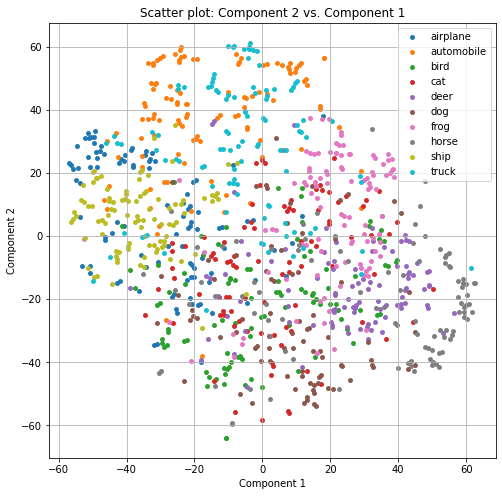

In [14]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

##**Assignment**: Explain what is a feature vector (hint: other terms in the literature are "Encodings", "Embeddings")

It is a vector containing relevant characteristics about our data (it can be the output of the convolutive part of a network like in the case of our baseline code it is the flatten layer)

##**Assignment**: Try out several perplexities: 5, 10, 30. What do you observe? 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


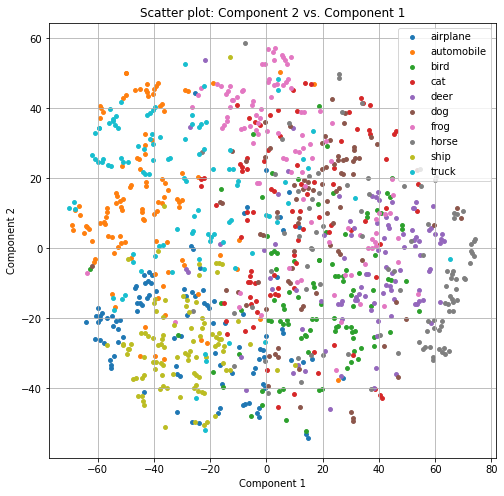

In [15]:
#perplexity=5
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


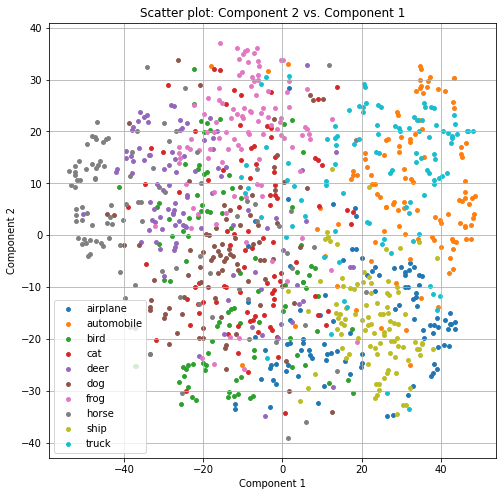

In [16]:
#perplexity=10
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


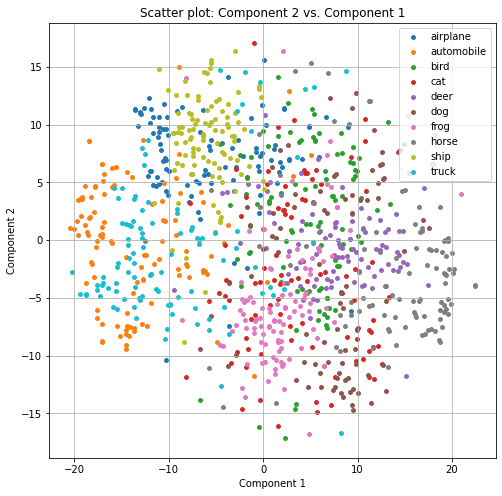

In [17]:
#perplexity=30
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

Conclusion: Large perplexities tends to produce clearer clusters

##**Assignment**: Visualize now the scores at the two fully connected layers. Why are the representations so strikingly different? Imagine you would like to use the same representations in another project (same image size, but other classes). Which of the representations seems less useful? Why? 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


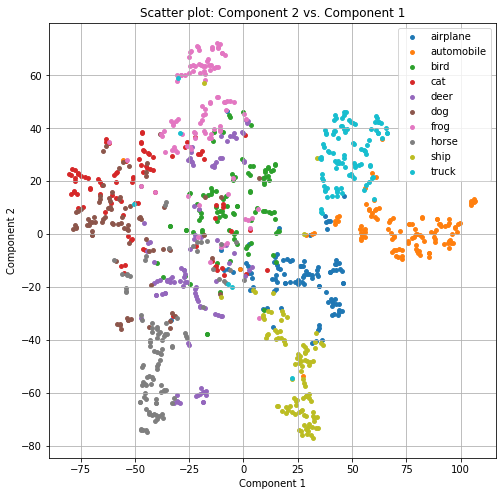

In [18]:
#Score of the first fully connected layer
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features2)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


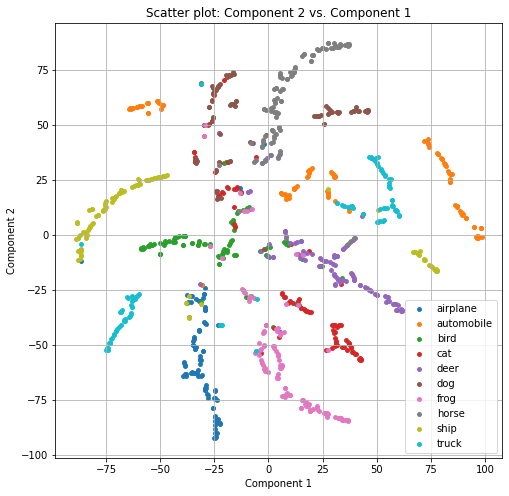

In [19]:
#Score of the last fully connected layer
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features3)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

These representations are so different because as we go through the layers of the neural network, the output of each laye is more and more specialised to our particular dataset.  

It will be better to use the first representation ie the output of the flatten layer, since the outputs of the dense layers are becoming very specialised to our dataset.

##**Assignment**: Visualize the tSNE plot of the model before training, what do you observe? (flatten layer and last fully_connected layer)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


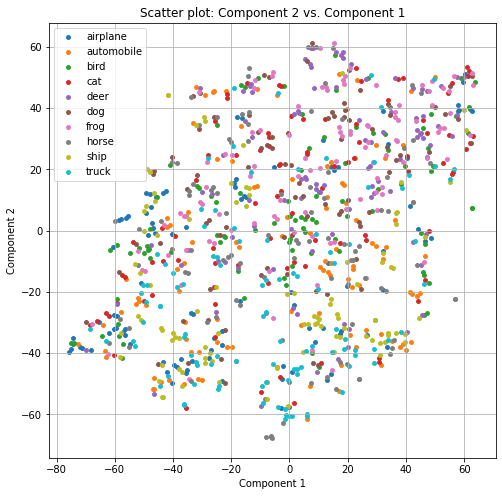

In [ ]:
#score of the flatten layer without training
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


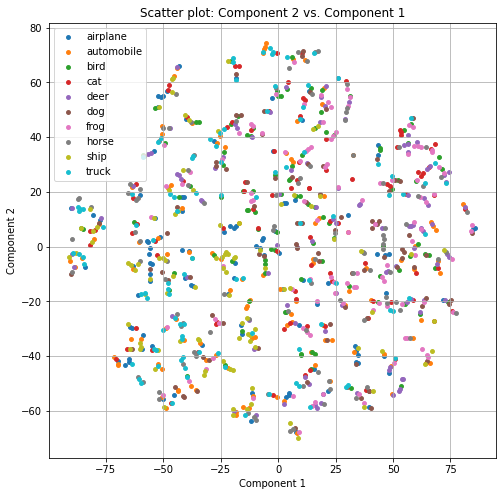

In [ ]:
#score of the last fully connected layer without training
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features3)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

Conclusion: Without training clusters are not formed 

# Classification activation maps (grad-CAM)

Classification activation maps provide certainly the most popular visualization methods for network inspection.

In [20]:
!pip install --upgrade tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 4.4 MB/s eta 0:00:00


In [21]:
from tf_keras_vis.gradcam import Gradcam

Next, we will load VGG16, pretrained on `ImageNet`. This is the network we are going to investigate. 

In [22]:
# Pretrained network: VGG16
from tensorflow.keras.applications import VGG16

# We want to extract the entire network, including the finaly layer.
model = VGG16(weights='imagenet',include_top=True)

# We show the summary of model (to recall the dimensions)
model.summary()

553467096/553467096 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

Now, we load an image from the `ImageNet` data base. We have downloaded these images: they are in the folder `imagenet`.

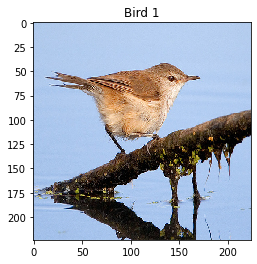

In [23]:
import os
filename = '418657219_3567961db1.jpg'

# animals:
# bird : filename = '418657219_3567961db1.jpg'
# dog : filename = '425248370_b15374000e.jpg'
# bird : filename = '485627874_8f4144223a.jpg'

# bridges: 
# filename = 'bridge1.jpg'
# filename = 'bridge2.jpg'
# filename = 'bridge3.jpg'

folder_name = '/content/gdrive/MyDrive'
# folder_name = '/content/gdrive/My Drive/Colab Notebooks/dlia_course/practical_sessions/imagenet'
from tensorflow.keras.preprocessing.image import load_img
image = load_img(os.path.join(folder_name, filename), target_size=(224, 224))
plt.title('Bird 1')
plt.imshow(image)


Now, we will predict the label of the image.

In [24]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# convert the image pixels to a numpy array
img_prep = img_to_array(image)

# reshape data (the model expects a batch of images.)
img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))

# prepare the image for the VGG model
img_prep = preprocess_input(img_prep)

# predict the probability across all output classes
img_prediction = model.predict(img_prep)

# the output is a 1000-dimensional vector of posterior probabilities.
print('Shape of the output vector:', img_prediction.shape)

# result
print('Prediction result:', decode_predictions(img_prediction, top=3))
max_index = np.argmax(img_prediction)
print('Solution Index: ', max_index)

1/1 [==============================] - 1s 870ms/step
Shape of the output vector: (1, 1000)
35363/35363 [==============================] - 0s 0us/step
Prediction result: [[('n01601694', 'water_ouzel', 0.9923922), ('n02027492', 'red-backed_sandpiper', 0.0048548467), ('n02028035', 'redshank', 0.0018741108)]]
Solution Index:  20


We need to define a few helper functions. First the `model_modifier` that replaces the `softmax` by a linear layer. The reason is that we cannot study the influence of neurons on the output $y_k$, if the output depends on all classes (which is the case when we use `softmax`). 

In [25]:
# model modifier
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss(img_prediction):
    # the loss gives the score of the image for the correct class. 
    # if you want to test the importance for the prediction of another class
    # you have to adapt the index accordingly.
    correct_class_index = np.argmax(img_prediction)
    return img_prediction[0][correct_class_index]

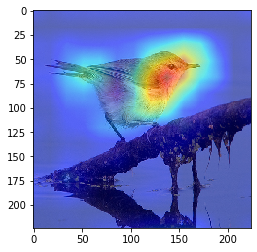

In [26]:
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              img_prep,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

plt.imshow(image)
heatmap = np.uint8(cm.jet(cam[0]) * 255)
plt.imshow(heatmap, cmap='jet', alpha=0.5)


##**Assignment:** Test the grad-CAM first on the three animal images, and verify that you obtain a reasonable result. Then test the algorithm on the three bridge images. Visualize the top-3 predictions.(Make a nice plot with the results)

*   For `Bridge1.jpg` you obtain a wrong classification, but what can be said about the learned network in view of the visualization of the top-3 predictions? 
*   For `Bridge3.jpg` you get the right result, but what can you say about the "understanding" of the image in view of your visualization result? 

Note that the correspondence of class names and indices can be found at: 
[ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)


1/1 [==============================] - 0s 25ms/step
Prediction result: [[('n01601694', 'water_ouzel', 0.9923922), ('n02027492', 'red-backed_sandpiper', 0.0048548467), ('n02028035', 'redshank', 0.0018741108)]]
Solution Index:  20
1/1 [==============================] - 0s 22ms/step
Prediction result: [[('n02096051', 'Airedale', 0.8946056), ('n02095314', 'wire-haired_fox_terrier', 0.021226738), ('n02097209', 'standard_schnauzer', 0.015890969)]]
Solution Index:  191
1/1 [==============================] - 0s 26ms/step
Prediction result: [[('n01828970', 'bee_eater', 0.94909185), ('n01820546', 'lorikeet', 0.016209003), ('n01843383', 'toucan', 0.013918705)]]
Solution Index:  92


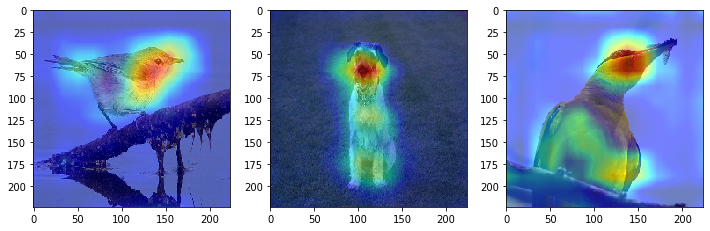

In [29]:
import os
# animals:
filename_bird1 = '418657219_3567961db1.jpg'
filename_dog = '425248370_b15374000e.jpg'
filename_bird2 = '485627874_8f4144223a.jpg'

folder_name = '/content/gdrive/MyDrive/imagenet-20230217T132223Z-001/imagenet'

image_bird1 = load_img(os.path.join(folder_name, filename_bird1), target_size=(224, 224))
image_dog = load_img(os.path.join(folder_name, filename_dog), target_size=(224, 224))
image_bird2 = load_img(os.path.join(folder_name, filename_bird2), target_size=(224, 224))

image_list = [image_bird1,image_dog, image_bird2]


fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 6))
list_axes = [ax0, ax1, ax2]
for i in range(len(image_list)) :
  # convert the image pixels to a numpy array
  img_prep = img_to_array(image_list[i])

  # reshape data (the model expects a batch of images.)
  img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))

  # prepare the image for the VGG model
  img_prep = preprocess_input(img_prep)

  # predict the probability across all output classes
  img_prediction = model.predict(img_prep)


  # result
  print('Prediction result:', decode_predictions(img_prediction, top=3))
  max_index = np.argmax(img_prediction)
  print('Solution Index: ', max_index)

  # Create Gradcam object
  gradcam = Gradcam(model,
                    model_modifier=model_modifier,
                    clone=False)

  # Generate heatmap with GradCAM
  cam = gradcam(loss,
                img_prep,
                penultimate_layer=-1, # model.layers number
              )
  cam = normalize(cam)

  list_axes[i].imshow(image_list[i])
  heatmap = np.uint8(cm.jet(cam[0]) * 255)
  list_axes[i].imshow(heatmap, cmap='jet', alpha=0.5)

Prediction result: [[('n01828970', 'bee_eater', 0.94909185), ('n01820546', 'lorikeet', 0.016209003), ('n01843383', 'toucan', 0.013918705)]]
Solution Index:  92
1/1 [==============================] - 0s 22ms/step
Prediction result: [[('n03344393', 'fireboat', 0.23944385), ('n04311004', 'steel_arch_bridge', 0.17773722), ('n04606251', 'wreck', 0.12663227)]]
Solution Index:  554
1/1 [==============================] - 0s 23ms/step
Prediction result: [[('n04311004', 'steel_arch_bridge', 0.33024156), ('n04356056', 'sunglasses', 0.1064743), ('n02879718', 'bow', 0.10036886)]]
Solution Index:  821
1/1 [==============================] - 0s 24ms/step


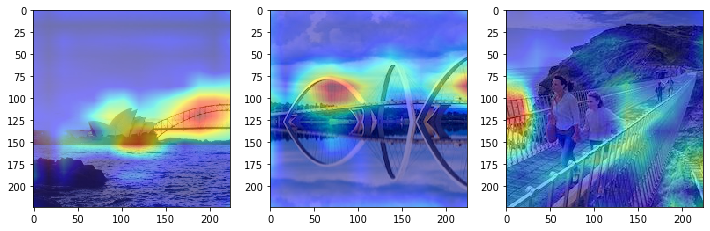

In [30]:
import os
# bridges: 
filename_bridge1 = 'bridge1.jpg'
filename_bridge2 = 'bridge2.jpg'
filename_bridge3 = 'bridge3.jpg'

folder_name = '/content/gdrive/MyDrive/imagenet-20230217T132223Z-001/imagenet'


image_bridge1 = load_img(os.path.join(folder_name, filename_bridge1), target_size=(224, 224))
image_bridge2 = load_img(os.path.join(folder_name, filename_bridge2), target_size=(224, 224))
image_bridge3 = load_img(os.path.join(folder_name, filename_bridge3), target_size=(224, 224))

image_list = [image_bridge1,image_bridge2, image_bridge3]


fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 6))
list_axes = [ax0, ax1, ax2]
for i in range(len(image_list)) :
  # convert the image pixels to a numpy array
  img_prep = img_to_array(image_list[i])

  # reshape data (the model expects a batch of images.)
  img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))

  # prepare the image for the VGG model
  img_prep = preprocess_input(img_prep)

  # result
  print('Prediction result:', decode_predictions(img_prediction, top=3))
  max_index = np.argmax(img_prediction)
  print('Solution Index: ', max_index)

  # predict the probability across all output classes
  img_prediction = model.predict(img_prep)

  # Create Gradcam object
  gradcam = Gradcam(model,
                    model_modifier=model_modifier,
                    clone=False)

  # Generate heatmap with GradCAM
  cam = gradcam(loss,
                img_prep,
                penultimate_layer=-1, # model.layers number
              )
  cam = normalize(cam)

  list_axes[i].imshow(image_list[i])
  heatmap = np.uint8(cm.jet(cam[0]) * 255)
  list_axes[i].imshow(heatmap, cmap='jet', alpha=0.5)

The Bridge1 prediction is wrong because we can see on the visualization above that the learned network focuses on the bridge but also on the building.

The Bridge3 prediction is true because the learned network focuses on every side of the bridge.

# Activation Maximization

So far, we visualized activations of images, i.e. we focused on visualizations of inner network representations for given image data.

We can also visualize properties of the network itself. A popular method is the activation maximization, where we seek an image that would maximize a given neuron inside the network. 

For this, we solve the maximization problem: 
\begin{equation}
x^{\ast} = {\arg \max}_{x} z(x)
\end{equation}
where $z(x)$ is the value of an arbitrary neuron (or a set of neurons, e.g. the neurons in one feature map) in the network. 

Typically, $z(x)=S_c(x)$ is the value of the output layer for one particular class. We therefore seek the image that maximizes the output for a particular class (e.g. the output for `water_ouzel`, `index: 20`). 

<ipython-input-31-55d8a96d483c>:18: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[54.20780944824219]],	Regularization: [('TotalVariation2D', [4.65433931350708]), ('Norm', [38.175086975097656])]
Steps: 100	Scores: [[82.55501556396484]],	Regularization: [('TotalVariation2D', [4.667445659637451]), ('Norm', [38.12508773803711])]
Steps: 150	Scores: [[109.34081268310547]],	Regularization: [('TotalVariation2D', [4.979987144470215]), ('Norm', [38.109683990478516])]
Steps: 200	Scores: [[134.11102294921875]],	Regularization: [('TotalVariation2D', [5.172397136688232]), ('Norm', [38.09477996826172])]


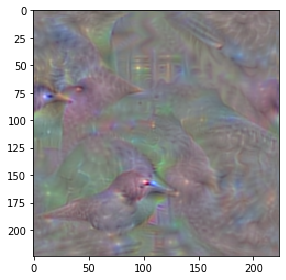

In [31]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior() 

# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 20

from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()


##**Assignment**: You might want to play with this, e.g. 385: Indian elephant, 2: great white shark, 555: fire truck

Other classes can be found at: 
[ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

<ipython-input-32-abca257ae21b>:17: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[70.79483795166016]],	Regularization: [('TotalVariation2D', [5.0872344970703125]), ('Norm', [38.198368072509766])]
Steps: 100	Scores: [[108.06604766845703]],	Regularization: [('TotalVariation2D', [5.296350002288818]), ('Norm', [38.17757034301758])]
Steps: 150	Scores: [[154.3361053466797]],	Regularization: [('TotalVariation2D', [5.491591453552246]), ('Norm', [38.17105484008789])]
Steps: 200	Scores: [[133.85841369628906]],	Regularization: [('TotalVariation2D', [5.738492488861084]), ('Norm', [38.18265914916992])]


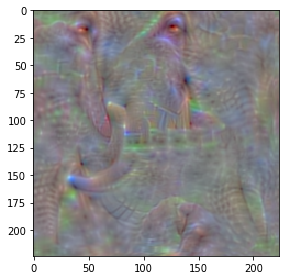

In [32]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 385

from tf_keras_vis.activation_maximization import ActivationMaximization
from tensorflow.python.ops.numpy_ops   import np_config
np_config.enable_numpy_behavior()

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()


<ipython-input-33-2c4b0dcf29d0>:17: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[56.36067581176758]],	Regularization: [('TotalVariation2D', [4.5163469314575195]), ('Norm', [38.19602966308594])]
Steps: 100	Scores: [[116.5041275024414]],	Regularization: [('TotalVariation2D', [4.726467132568359]), ('Norm', [38.1564826965332])]
Steps: 150	Scores: [[122.10562133789062]],	Regularization: [('TotalVariation2D', [5.51094388961792]), ('Norm', [38.144771575927734])]
Steps: 200	Scores: [[130.0525360107422]],	Regularization: [('TotalVariation2D', [5.109488010406494]), ('Norm', [38.10261154174805])]


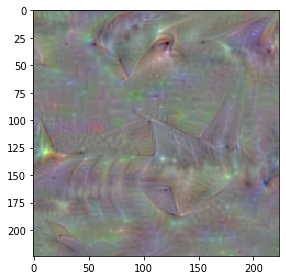

In [33]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 2

from tf_keras_vis.activation_maximization import ActivationMaximization
from tensorflow.python.ops.numpy_ops   import np_config
np_config.enable_numpy_behavior()

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()


<ipython-input-34-3925b3d109b3>:17: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[30.591407775878906]],	Regularization: [('TotalVariation2D', [3.868074417114258]), ('Norm', [38.2095947265625])]
Steps: 100	Scores: [[67.91458129882812]],	Regularization: [('TotalVariation2D', [3.68058180809021]), ('Norm', [38.14287567138672])]
Steps: 150	Scores: [[72.80754089355469]],	Regularization: [('TotalVariation2D', [3.9970030784606934]), ('Norm', [38.09195327758789])]
Steps: 200	Scores: [[94.74552917480469]],	Regularization: [('TotalVariation2D', [4.050355911254883]), ('Norm', [38.06964111328125])]


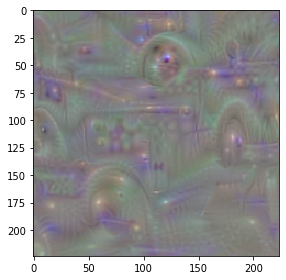

In [34]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 555

from tf_keras_vis.activation_maximization import ActivationMaximization
from tensorflow.python.ops.numpy_ops   import np_config
np_config.enable_numpy_behavior()

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()


##**Assignment:** Generate the activation maximization image the the same index, for a network initialized randomly. What do you observe? 

In [39]:
# Pretrained network: VGG19
from tensorflow.keras.applications import VGG19

# We want to extract the entire network, including the finaly layer.
model2 = VGG19(weights= None, include_top=True)

# We show the summary of model (to recall the dimensions)
model2.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<ipython-input-40-9ffdf2b6c5e9>:17: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[0.0057563334703445435]],	Regularization: [('TotalVariation2D', [3.1453449726104736]), ('Norm', [38.13423156738281])]
Steps: 100	Scores: [[0.007841363549232483]],	Regularization: [('TotalVariation2D', [1.3587841987609863]), ('Norm', [38.03669738769531])]
Steps: 150	Scores: [[0.008176669478416443]],	Regularization: [('TotalVariation2D', [0.8186163306236267]), ('Norm', [37.94029235839844])]
Steps: 200	Scores: [[0.009408466517925262]],	Regularization: [('TotalVariation2D', [0.5722011923789978]), ('Norm', [37.84748458862305])]


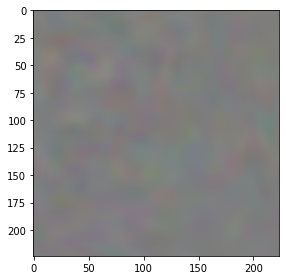

In [40]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 20

from tf_keras_vis.activation_maximization import ActivationMaximization
from tensorflow.python.ops.numpy_ops   import np_config
np_config.enable_numpy_behavior()

activation_maximization = ActivationMaximization(model2,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()
